In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_score, recall_score, roc_auc_score
)
from sklearn.model_selection import GridSearchCV

%matplotlib inline

print("Libraries imported successfully.")

Libraries imported successfully.


In [5]:

train_data = pd.read_csv('data/processed_train_data.csv')
validation_data = pd.read_csv('data/processed_validation_data.csv')
test_data = pd.read_csv('data/processed_test_data.csv')

print("Train data shape:", train_data.shape)
print("Validation data shape:", validation_data.shape)
print("Test data shape:", test_data.shape)

X_train = train_data.drop('status', axis=1)
y_train = train_data['status']

X_val = validation_data.drop('status', axis=1)
y_val = validation_data['status']

X_test = test_data.drop('status', axis=1)
y_test = test_data['status']

Train data shape: (6286, 8)
Validation data shape: (1714, 8)
Test data shape: (3430, 8)


In [6]:

models = {
    "Logistic Regression": {
        "estimator": LogisticRegression(random_state=42, max_iter=1000),
        "param_grid": {
            "C": [0.001, 0.01, 0.1, 1, 10, 100]
        }
    },
    "Random Forest": {
        "estimator": RandomForestClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 5, 10],
            "min_samples_split": [2, 5]
        }
    },
    "Gradient Boosting": {
        "estimator": GradientBoostingClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7]
        }
    },
    "SVC": {
        "estimator": SVC(probability=True, random_state=42),
        "param_grid": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"]
        }
    }
}

results = []  

print("Starting hyperparameter tuning and evaluation on the validation set...\n")
for name, model_info in models.items():
    print(f"--- Tuning {name} ---")
    estimator = model_info["estimator"]
    param_grid = model_info["param_grid"]
    
    grid = GridSearchCV(estimator, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    if hasattr(best_model, "predict_proba"):
        val_probs = best_model.predict_proba(X_val)[:, 1]
    else:
        val_probs = best_model.decision_function(X_val)
    val_auc = roc_auc_score(y_val, val_probs)
    print(f"Best parameters: {grid.best_params_}")
    print(f"Validation ROC AUC: {val_auc:.3f}\n")
    
    results.append((name, grid.best_params_, val_auc, best_model))

# Select the best candidate based on validation ROC AUC!
best_candidate = max(results, key=lambda x: x[2])
print("Best Candidate Model:")
print(f"Model: {best_candidate[0]}")
print(f"Best Parameters: {best_candidate[1]}")
print(f"Validation ROC AUC: {best_candidate[2]:.3f}")

Starting hyperparameter tuning and evaluation on the validation set...

--- Tuning Logistic Regression ---
Best parameters: {'C': 10}
Validation ROC AUC: 0.774

--- Tuning Random Forest ---
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Validation ROC AUC: 0.891

--- Tuning Gradient Boosting ---
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Validation ROC AUC: 0.879

--- Tuning SVC ---
Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Validation ROC AUC: 0.851

Best Candidate Model:
Model: Random Forest
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Validation ROC AUC: 0.891


Matriz de Confusión:
[[1392  323]
 [ 349 1366]]

Precisión: 0.8087625814091178
Recall: 0.7965014577259475

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1715
           1       0.81      0.80      0.80      1715

    accuracy                           0.80      3430
   macro avg       0.80      0.80      0.80      3430
weighted avg       0.80      0.80      0.80      3430

Test AUC: 0.8872537803126249


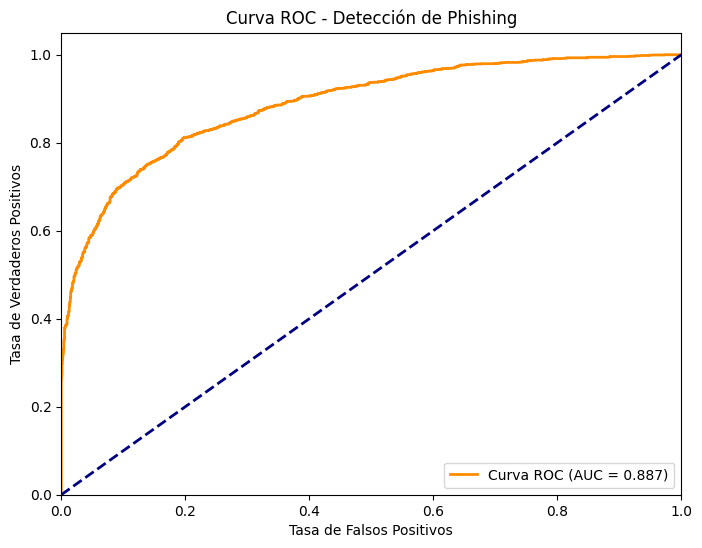

In [7]:
best_model = best_candidate[3]

test_predictions = best_model.predict(X_test)
if hasattr(best_model, "predict_proba"):
    test_probs = best_model.predict_proba(X_test)[:, 1]
else:
    test_probs = best_model.decision_function(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions)
print("Matriz de Confusión:")
print(cm)

# Calculate precision and recall
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
print("\nPrecisión:", precision)
print("Recall:", recall)

# Detailed classification report
print("\nReporte de Clasificación:")
print(classification_report(y_test, test_predictions))

# Compute ROC curve and AUC on test data
fpr, tpr, thresholds = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)
print("Test AUC:", roc_auc)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Detección de Phishing')
plt.legend(loc="lower right")
plt.show()

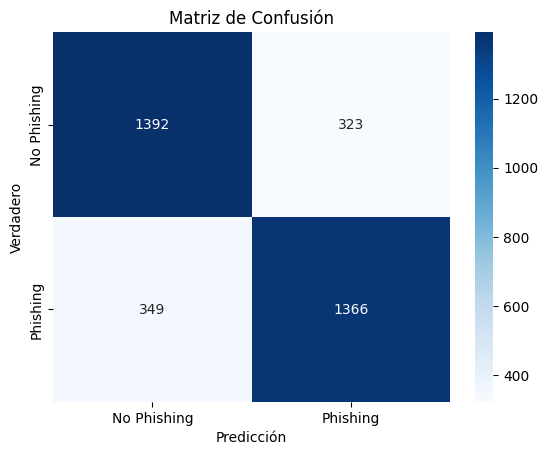

In [8]:
# Graph confusion matrix 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Phishing', 'Phishing'], yticklabels=['No Phishing', 'Phishing'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

